In [1]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

### Connection: Stability Testing for Small Data
Standard statistical uncertainty methods (like standard deviation) often fail with small samples because they rely on asymptotic assumptions (like the Central Limit Theorem) that require large amounts of data,.

Gnostic Interval Analysis connects to uncertainty by treating the small sample as a single geometric object and performing a **sensitivity test**. It mathematically extends the sample with one "free" datum ($Z_x$) that varies from zero to infinity. By observing how the sample's center (location parameter $Z_0$) reacts to this stress test, we can quantify uncertainty without assuming a Gaussian distribution.

### Interpretation of Intervals

#### 1. Tolerance Interval $[Z_{0L}, Z_{0U}]$: The Stability of the Estimate
*   **Definition:** This interval defines the maximum possible shift in the sample's center ($Z_0$). Even if the hypothetical added datum ($Z_x$) moves to infinity (an extreme outlier), the sample's center will **never** move outside these bounds.
*   **Interpretation:** This measures the **robustness** of your measurement. A narrow tolerance interval confirms that your estimate is stable and not easily corrupted by gross errors or outliers, which is critical when working with limited data points,.

#### 2. Typical Data Interval $[Z_L, Z_U]$: The Validity Range
*   **Definition:** This interval is wider than the tolerance interval. It is defined by the mathematical reaction of the sample's center to the added datum:
    *   **Inside $[Z_L, Z_U]$:** The sample "accepts" the new datum. The location parameter moves *toward* the new value (attraction).
    *   **Outside $[Z_L, Z_U]$:** The sample "rejects" the new datum. The location parameter moves *away* from it (repulsion). The sample defends its internal structure against the foreign element,.
*   **Interpretation:** This defines what is **physically characteristic** for the measured object. Measurements falling inside are "typical" and confirm the current sample structure. Measurements outside are likely errors, contamination, or belong to a different process.


# Uncertainty Analysis

Example: Pressure measurements from a Pulsating Heat Pipe experiment. In this scenario, data collection is limited because each experiment is time-consuming and costly. As a result, obtaining a large number of repeated measurements is impractical. To address the inherent uncertainty in such small, expensive datasets, we apply Machine Gnostics interval analysis for robust and interpretable uncertainty quantification.



In [2]:
# pressure data from PHP experiment
import numpy as np
data = np.array([0.75, 0.75, 0.71, 0.69, 0.89])

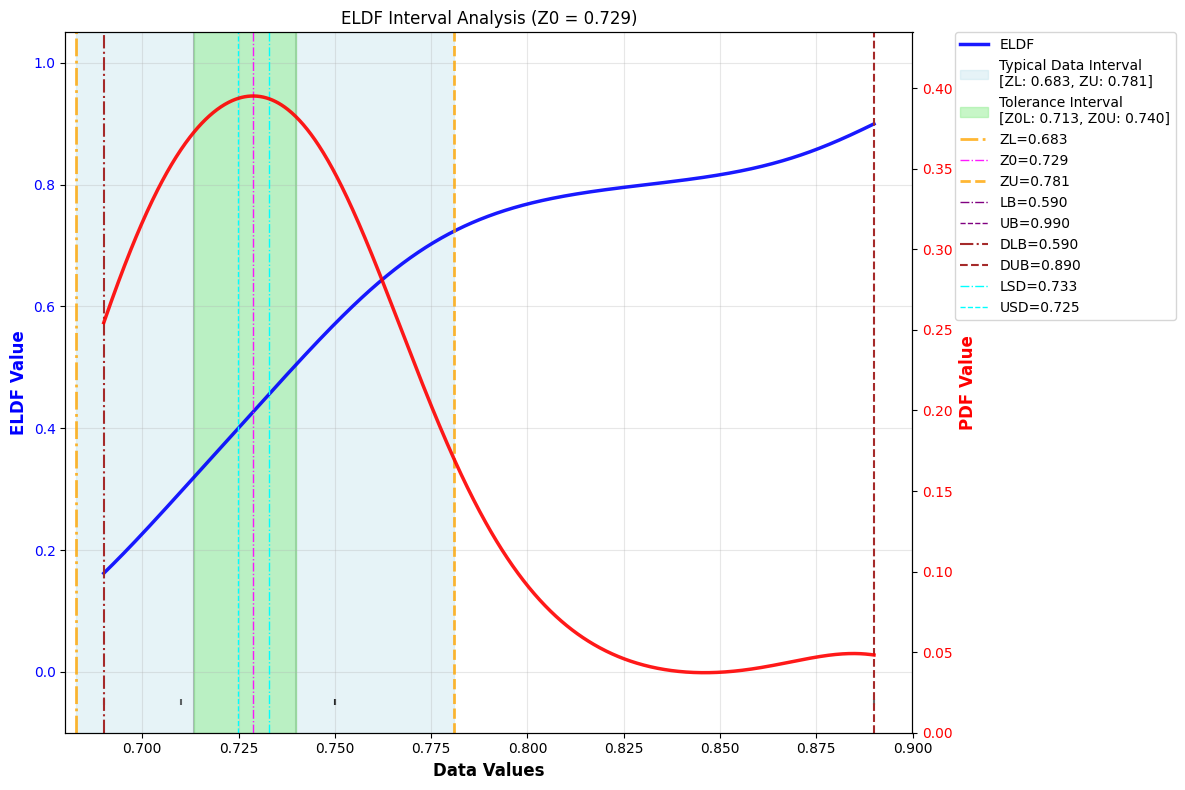

In [3]:
from machinegnostics.magcal import IntervalAnalysis

# create interval analysis object
ia = IntervalAnalysis(wedf=False)

# fit the data
intervals = ia.fit(data, plot=True)


In [4]:
# print intervals
# data certification
ia.results()

{'LB': 0.5900357680956452,
 'LSB': 0.684929997753483,
 'DLB': 0.69,
 'LCB': 0.69,
 'LSD': 0.7328552445203824,
 'ZL': 0.6826785930903282,
 'Z0L': 0.7133257274668343,
 'Z0': 0.7288,
 'Z0U': 0.7398556947316381,
 'ZU': 0.7809693864519414,
 'USD': 0.7247447554796176,
 'UCB': 0.832,
 'DUB': 0.89,
 'USB': 0.895070002246517,
 'UB': 0.9900469434350458}

In [5]:
# Get interval results
results = ia.results()

# Extract values
Z0 = results['Z0']      # Mean value (center)
Z0L = results['Z0L']    # Tolerance interval lower
Z0U = results['Z0U']    # Tolerance interval upper
ZL = results['ZL']      # Typical data interval lower
ZU = results['ZU']      # Typical data interval upper

# Gnostic intervals
tolerance_interval = Z0U - Z0L
typical_data_interval = ZU - ZL

print(f"Mean (Z0): {Z0}")
print(f"Tolerance Interval: [{Z0L}, {Z0U}] with width {tolerance_interval}")
print(f"Typical Data Interval: [{ZL}, {ZU}] with width {typical_data_interval}")


Mean (Z0): 0.7288
Tolerance Interval: [0.7133257274668343, 0.7398556947316381] with width 0.026529967264803833
Typical Data Interval: [0.6826785930903282, 0.7809693864519414] with width 0.09829079336161317


# GDF vs. 95% Statistical Expanded Uncertainty
This plot compares Machine Gnostics intervals (typical and tolerance) with a conventional 95% statistical expanded uncertainty for the mean. The expanded uncertainty uses a Student-t coverage factor to account for small-sample effects.

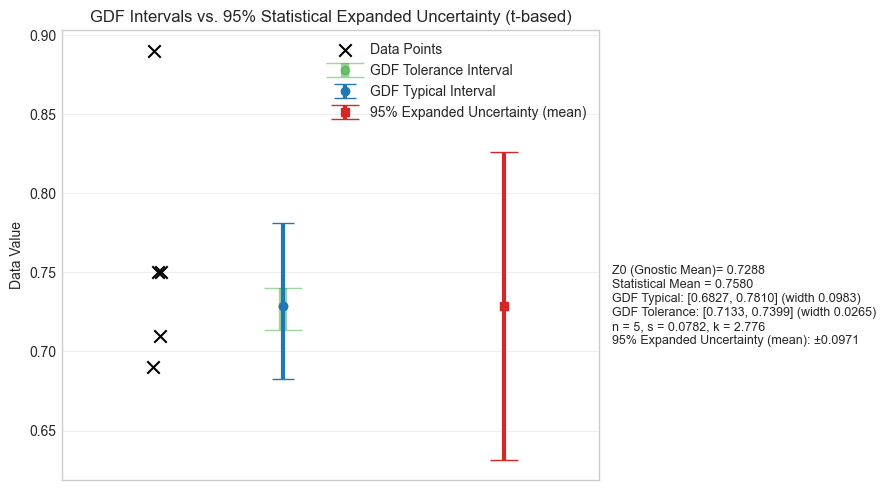

In [6]:
# Compare GDF intervals with 95% statistical expanded uncertainty
import numpy as np
import matplotlib.pyplot as plt

# Try to use Student-t coverage factor; fallback to normal approx if SciPy unavailable
try:
    from scipy.stats import t
    has_scipy = True
except Exception:
    has_scipy = False

# Existing results from IntervalAnalysis
# Z0 (mean/center), Z0L/Z0U (tolerance), ZL/ZU (typical) should already be defined above
n = len(data)
s = np.std(data, ddof=1)            # sample std dev
u_mean = s / np.sqrt(n)              # standard uncertainty of the mean
k = t.ppf(0.975, df=n-1) if has_scipy else 1.96  # 95% coverage factor
U95 = k * u_mean                     # expanded uncertainty (mean ± U95)

# GDF intervals around Z0
typical_lower = Z0 - ZL
typical_upper = ZU - Z0
tolerance_lower = Z0 - Z0L
tolerance_upper = Z0U - Z0

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(9, 5))

x_data = 0.8      # data points
x_gdf = 1.0       # GDF intervals
x_stat = 1.35     # statistical expanded uncertainty

# Data points (slight horizontal jitter for visibility)
rng = np.random.default_rng(7)
jitter = (rng.random(len(data)) - 0.5) * 0.02
ax.scatter([x_data + j for j in jitter], data, color='black', marker='x', s=80, label='Data Points', zorder=3)

# GDF tolerance interval (thick, behind)
ax.errorbar(x_gdf, Z0,
            yerr=[[tolerance_lower], [tolerance_upper]],
            fmt='o', markersize=6, capsize=14, elinewidth=6,
            color='tab:green', alpha=0.45, label='GDF Tolerance Interval', zorder=1)

# GDF typical interval (in front)
ax.errorbar(x_gdf, Z0,
            yerr=[[typical_lower], [typical_upper]],
            fmt='o', markersize=6, capsize=8, elinewidth=3,
            color='tab:blue', label='GDF Typical Interval', zorder=2)

# 95% statistical expanded uncertainty for the mean (t-based if available)
ax.errorbar(x_stat, Z0,
            yerr=[[U95], [U95]],
            fmt='s', markersize=6, capsize=10, elinewidth=3,
            color='tab:red', label='95% Expanded Uncertainty (mean)', zorder=2)

# Cosmetic tweaks
ax.set_xlim(0.65, 1.5)
ax.set_xticks([])
ax.set_ylabel('Data Value')
title_note = 't-based' if has_scipy else 'normal approx'
ax.set_title(f'GDF Intervals vs. 95% Statistical Expanded Uncertainty ({title_note})')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Annotate values for clarity
txt = [
    f"Z0 (Gnostic Mean)= {Z0:.4f}",
    f"Statistical Mean = {np.mean(data):.4f}",
    f"GDF Typical: [{ZL:.4f}, {ZU:.4f}] (width {ZU - ZL:.4f})",
    f"GDF Tolerance: [{Z0L:.4f}, {Z0U:.4f}] (width {Z0U - Z0L:.4f})",
    f"n = {n}, s = {s:.4f}, k = {k:.3f}",
    f"95% Expanded Uncertainty (mean): ±{U95:.4f}"
]
ax.text(1.52, Z0, '\n'.join(txt), va='center', fontsize=9)

plt.tight_layout()
plt.show()

### **Geometric vs. Probabilistic Bounds**

*   **Statistical Interval (Fixed Probability):** The statistical bounds (e.g., 95% Confidence) are determined by **subjectively** selecting a probability level first. They assume the data follows a specific theoretical shape (usually Gaussian) and force the interval to contain 95% of that theoretical curve.

*   **Gnostic Interval (Data-Driven Geometry):** The Gnostic bounds (Typical Data Interval, $[Z_L, Z_U]$) are determined **objectively** by the data's internal structure. These bounds mark the exact points where the data cluster switches from "attracting" to "repelling" new values.


**NOTE:** If the Gnostic interval is significantly different from the statistical one, it indicates your data does not fit the standard Gaussian assumption.
